In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/GP/landuse-scene-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000365.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000366.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000367.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000368.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000369.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000371.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000372.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000374.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000376.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000377.png  
  inflating: images_train_test_val/train/mediumre

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils.multiclass import unique_labels


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
''' to learn more about itertools visit
    https://medium.com/@jasonrigden/a-guide-to-python-itertools-82e5a306cdf8'''
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
#Import keras functions

from keras import Sequential

'''Since we are using transfer learning let's import the model that we want to implement.Let's use VGG 19(19 layers) and Resnet-50 (50 layers of residual units). 
Residual units allow us to add more layers onto the model without a degradation in accuracy.
Let's try and compare the accuracy of the 2 models and see if the addtional layers do make a significant difference. '''

from keras.applications import VGG19,ResNet50

'Import the datagenerator to augment images'
from keras.preprocessing.image import ImageDataGenerator

'''Import the optimizers and leanring rate annealer (which will reduce the learning rate once a particular metric we choose(in this case validation error) 
does not reduce after a user defined number of epochs)'''
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau

'Lastly import the final layers that will be added on top of the base model'
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout

'Import to_categorical from the keras utils package to one hot encode the labels'
from keras.utils import to_categorical

In [ ]:
#Data Augmentation Function: Let's define an instance of the ImageDataGenerator class and set the parameters.We have to instantiate for the Train,Validation and Test datasets
train_generator = ImageDataGenerator(rotation_range=15,zoom_range=0.1,horizontal_flip=True)

val_generator = ImageDataGenerator(rotation_range=15,zoom_range=0.1,horizontal_flip=True)

test_generator = ImageDataGenerator(rotation_range=15,zoom_range=0.1,horizontal_flip=True)

In [ ]:
src_path_train = "/content/images_train_test_val/train"
src_path_val = "/content/images_train_test_val/validation"
src_path_test = "/content/images_train_test_val/test"

In [ ]:
#Fit the augmentation method to the data
train_generatorr = train_generator.flow_from_directory(src_path_train,
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    target_size=(32,32),
                                                    shuffle=False,
                                                    seed=42)

validation_generator = train_generator.flow_from_directory(src_path_val,
                                                        target_size=(32,32),
                                                        batch_size=32,
                                                        color_mode="rgb",
                                                        class_mode='categorical',
                                                        shuffle=False,
                                                        seed=42)
test_generatorr = test_generator.flow_from_directory(
    src_path_test,
    target_size=(32,32),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [ ]:
lrr= ReduceLROnPlateau(verbose = 1,
                       monitor='val_loss', #Metric to be measured
                       factor=.1, #Factor by which learning rate will be reduced
                       patience=4,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-7,
                       min_delta = 0.001) #The minimum learning rate 

In [ ]:
base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=21)

In [ ]:
#Since we have already defined Resnet50 as base_model_2, let us build the sequential model.

model_2=Sequential()
#Add the Dense layers along with activation and batch normalization
model_2.add(base_model_2)
model_2.add(Flatten())


#Add the Dense layers along with activation and batch normalization
model_2.add(Dense(512,activation=('relu')))
model_2.add(Dropout(.3, seed = 42))
model_2.add(Dense(256,activation=('relu')))
model_2.add(Dense(21,activation=('softmax'))) #This is the classification layer

In [ ]:
model_2.layers[0].trainable = False

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 21)                5397      
                                                                 
Total params: 24,773,525
Trainable params: 1,185,813
N

In [ ]:
learn_rate=.0001

sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
hist = model_2.fit_generator(train_generatorr,
                      epochs=40,
                      steps_per_epoch = train_generatorr.samples // 32,
                      validation_data = validation_generator,
                      validation_steps = validation_generator.samples // 32,
                      callbacks=[lrr],verbose=1)

Epoch 1/40


<ipython-input-27-42ff5bf3d701>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_2.fit_generator(train_generatorr,


229/229 [==============================] - 41s 163ms/step - loss: 3.3731 - accuracy: 0.1775 - val_loss: 2.1425 - val_accuracy: 0.3596 - lr: 1.0000e-04
Epoch 2/40
229/229 [==============================] - 36s 157ms/step - loss: 2.2320 - accuracy: 0.3415 - val_loss: 1.7902 - val_accuracy: 0.4788 - lr: 1.0000e-04
Epoch 3/40
229/229 [==============================] - 32s 142ms/step - loss: 1.8756 - accuracy: 0.4345 - val_loss: 1.5534 - val_accuracy: 0.5394 - lr: 1.0000e-04
Epoch 4/40
229/229 [==============================] - 36s 158ms/step - loss: 1.6726 - accuracy: 0.4922 - val_loss: 1.4287 - val_accuracy: 0.5596 - lr: 1.0000e-04
Epoch 5/40
229/229 [==============================] - 36s 158ms/step - loss: 1.5131 - accuracy: 0.5253 - val_loss: 1.3530 - val_accuracy: 0.5808 - lr: 1.0000e-04
Epoch 6/40
229/229 [==============================] - 32s 141ms/step - loss: 1.4269 - accuracy: 0.5474 - val_loss: 1.3844 - val_accuracy: 0.5731 - lr: 1.0000e-04
Epoch 7/40
229/229 [===================

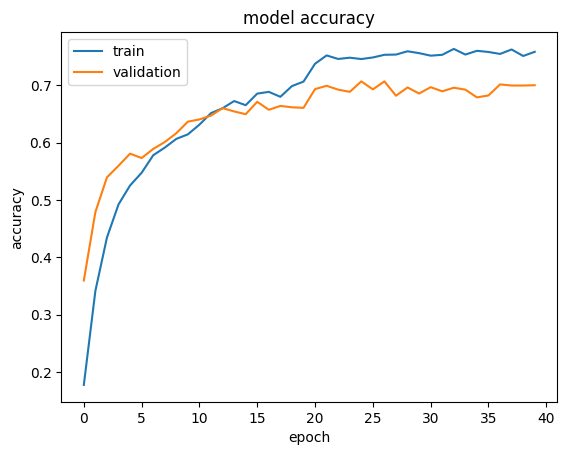

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

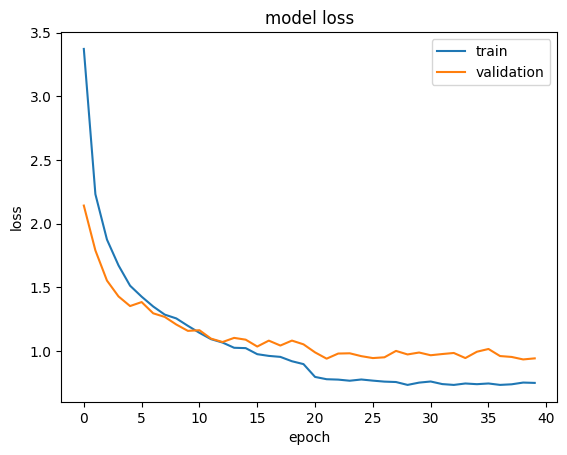

In [ ]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
predict = model_2.evaluate(test_generatorr)
# predict the class label
print(predict)

1050/1050 [==============================] - 13s 12ms/step - loss: 0.9841 - accuracy: 0.6933
[0.9840843677520752, 0.6933333277702332]


In [ ]:
model_2.save("Bicubic_LANDUSE_ResNet_.h5")